[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/%20Data_%20prep_%20level.ipynb)



> You need to run [Data prep1](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/01-RC_data_prep1.ipynb) and [Data prep2](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/02-RC_data_prep2.ipynb) notebooks before running this one to get the needed prepared data.



Run the first two cells if you open this notebook in Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%cd './drive/My Drive'

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from math import sqrt

#### Data source path 

In [0]:
data_source = './ewin_mex/data'
file_names = os.listdir(data_source)

Define a function that we can use to plot same weather parameter across nodes.

In [0]:
def myPlot(df,param):
  find_vars = [col for col in df.columns if param in col]
  df[find_vars].plot(subplots=True,
                  figsize=(12, 8),title= param, grid=True)

Read RiverCore data

In [6]:
rc_path = os.path.join(data_source,'rc_data.csv')
rc_data = pd.read_csv(rc_path,infer_datetime_format= True,
                  parse_dates=True,index_col='time_stamp')
rc_data.head()
rc_data.isna().sum()

air_temp_Atmos1        473
relative_hum_Atmos1    473
solar_rad_Atmos1       473
vapor_press_Atmos1     473
prcp_Atmos1            473
air_temp_Atmos2        578
relative_hum_Atmos2    578
solar_rad_Atmos2       578
vapor_press_Atmos2     578
prcp_Atmos2            578
air_temp_Atmos3        728
relative_hum_Atmos3    728
solar_rad_Atmos3       728
vapor_press_Atmos3     728
prcp_Atmos3            728
wl_target                1
sm_target                1
dtype: int64

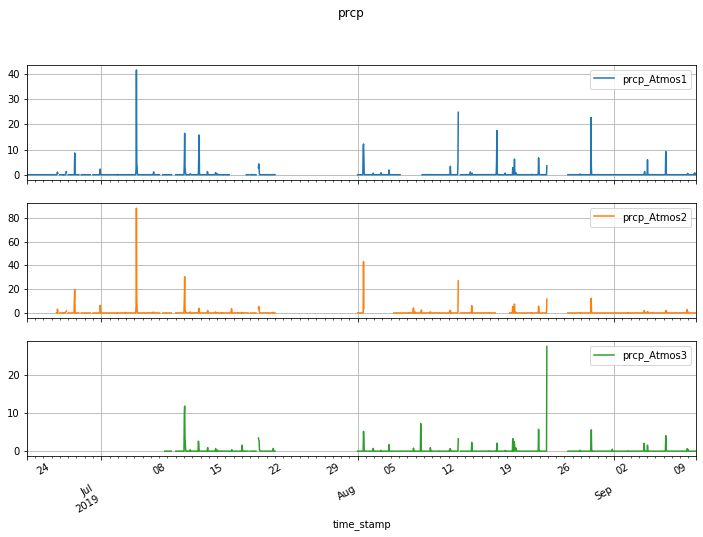

In [7]:
myPlot(rc_data,'prcp')

Given large gaps in the data, we are going to keep only data for August 

In [8]:
# keep data for August 
rc_august = rc_data.loc['2019-08-01':'2019-09-10']
# check Nans
rc_august.isna().sum()

air_temp_Atmos1        128
relative_hum_Atmos1    128
solar_rad_Atmos1       128
vapor_press_Atmos1     128
prcp_Atmos1            128
air_temp_Atmos2        194
relative_hum_Atmos2    194
solar_rad_Atmos2       194
vapor_press_Atmos2     194
prcp_Atmos2            194
air_temp_Atmos3         66
relative_hum_Atmos3     66
solar_rad_Atmos3        66
vapor_press_Atmos3      66
prcp_Atmos3             66
wl_target                0
sm_target                0
dtype: int64

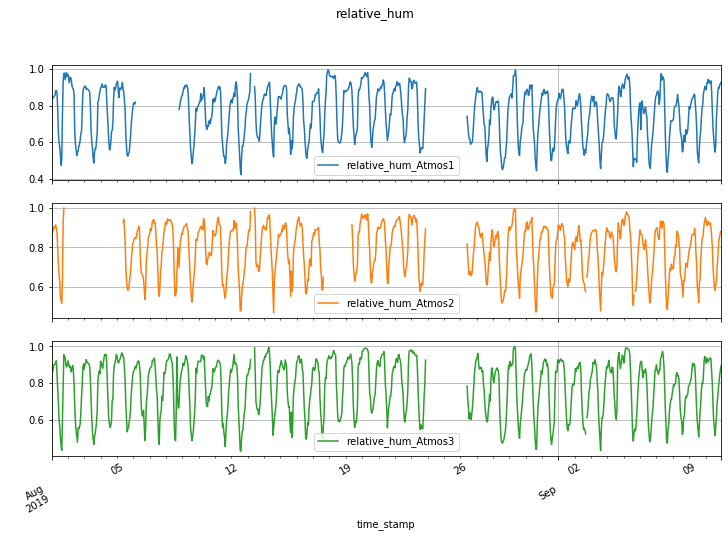

In [9]:
# plot 
myPlot(rc_august,'relative_hum')

Fill the gaps with zeros for prcp and mean values for the rest of the paramaters

In [10]:
# fill prcp with zeros and the rest with mean 
for column in rc_august:
  print(column)
  if 'prcp' in column:
    rc_august[column] = rc_august[column].fillna(0)
  else:
    rc_august[column] = rc_august[column].fillna(rc_august[column].mean())

air_temp_Atmos1
relative_hum_Atmos1
solar_rad_Atmos1
vapor_press_Atmos1
prcp_Atmos1
air_temp_Atmos2
relative_hum_Atmos2
solar_rad_Atmos2
vapor_press_Atmos2
prcp_Atmos2
air_temp_Atmos3
relative_hum_Atmos3
solar_rad_Atmos3
vapor_press_Atmos3
prcp_Atmos3
wl_target
sm_target


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.




---

Implement some basic machine learning models

In [0]:
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

Re-arrange the data and put the the target station in the first column 

In [0]:
# prepare the data
arranged = ['wl_target'] + list(rc_august.columns.drop('wl_target'))
rc_august = rc_august[arranged]
# to np array 
rc_dataNp = rc_august.values

After the first preparation of the data, we now need to frame the dataset as a supervised learning problem.
For example we can re-arrange the data in a way that will allow predicting the water level at the target site at the current hour (t) given the water level measurements and other weather conditions at the prior time steps at the upstream site.

The function below implement this by taking the data, the lead time desired and lag time (prior time steps desired to include in the inputs) 

In [0]:
	# convert time series into supervised learning problem
def to_lagLead(data, lead,lag, dropnan=True):
	n_vars = data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# keep the tagret
	cols.append(df.iloc[:,0])
	# input sequence (t-n, ... t-1)
	lag = lag + lead
	for i in range(lag, lead-1, -1): #i=2
		cols.append(df.shift(i))
		names += [('input%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	df_all = pd.concat(cols, axis=1)
	names = ["t"] +names
	df_all.columns = names
	# drop rows with NaN values
	if dropnan:
	  df_all.dropna(subset=[df_all.columns[1]],inplace=True) # drop only NAN's generagted by the lag process
	return df_all

Below, we are going to prepare a dictionary of machine learning models, using the great [scikit-learn](https://scikit-learn.org/stable/) library.
For illustration, we are going to use a basic linear model, k nearest neighbor, Support Vector machine and a Random forest. 

In [0]:
	# prepare a dict. of ml models
def get_models(models=dict()):
  # linear models
  models['lr'] = LinearRegression()
  # non-linear models
  models['knn'] = KNeighborsRegressor()
  models['svmr'] = SVR()
  # ensemble models
  models['rf'] = RandomForestRegressor()
  print('The number of models are %d:' % len(models))
  for key, value in models.items() :
    print (key)
  return models

Data pre-processing is an essential step in machine learning, for example, Normalization which is a technique often applied as part of data preparation for machine learning. The goal is to change the values of numeric variables in the dataset to a common scale, without distorting differences in the ranges of values.

For that, we will be using the scikit-learn, Pipelines to be able to chain multiple steps (e.g. different types of pre-processing techniques). 
For more info refer to the scikit-learn, [Pipelines](https://scikit-learn.org/stable/modules/compose.html) 

In [0]:
	# create a feature preparation pipeline for a model
def make_pipeline(model,scaleType):
  """scaleType takes only 'normalize' or 'standardize'"""
  steps = list()
  # standardization
  if scaleType == 'standardize':
    steps.append(('standardize', StandardScaler()))
  # normalization
  if scaleType == 'normalize':
      steps.append(('normalize', MinMaxScaler()))
  # the model
  steps.append(('model', model))
  # create pipeline
  pipeline = Pipeline(steps=steps)
  return pipeline 


Let's run an experiment where we will predict the water level 4 hours ahead using lagged inputs of up to 4 hours for each variable including data from the target site. This can be achieved using the defined above function `to_lagLead` 

In [0]:
# run the experiement 
lagged_data =to_lagLead(rc_dataNp, lead = 4, lag = 4) 

Here we use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) `train_test_split` to split the data to train and test. 

In [0]:
# train and test split 
train, test = train_test_split(lagged_data.values, test_size=0.2)

Define train and target for both train set and test set 

In [0]:
# define train and target
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

get the defined models

In [20]:
# make pipeline
models = get_models()

The number of models are 4 models:
lr
knn
svmr
rf


Below we fit each defined model to the train data and make a prediction using the test set then calculate performance the score for each model. 

In [34]:
scores = pd.DataFrame()
obs_pred =pd.DataFrame()
for name, model in models.items():
  print('model: %s' % name)
  pipeline = make_pipeline(model=model,scaleType='normalize')
  # fit the model
  pipeline.fit(train_X, train_y)
  # forecast
  yhat = pipeline.predict(test_X)
  # calculate scores
  rmse = sqrt(sm.mean_squared_error(test_y, yhat))
  mae = sm.mean_absolute_error(test_y, yhat)
  r2 = sm.r2_score(test_y, yhat)
  ev = sm.explained_variance_score(test_y, yhat)
  df = {'model' : name,'rmse' : rmse,'mae' : mae,
        'r2' : r2,'ev':ev}
  scores = scores.append(df,ignore_index=True)
  yhat_tstY = pd.DataFrame({'model' : name,'obs' : test_y,'preds' : yhat})
  obs_pred = obs_pred.append(yhat_tstY)

,model,obs,preds
0,lr,0.295796,0.290536
1,lr,0.316034,0.326420
2,lr,0.302800,0.314196
3,lr,0.276780,0.273216
4,lr,0.203729,0.228646
...,...,...,...
191,rf,0.263396,0.262245
192,rf,0.310847,0.314350
193,rf,0.251111,0.244466
194,rf,0.365273,0.381543


Plot rmse and mae 

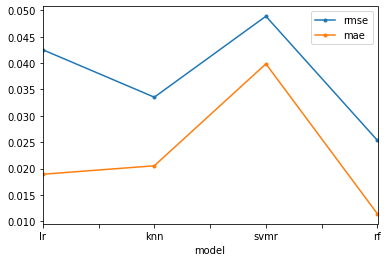

In [30]:
scores.plot(x = 'model',y = ['rmse','mae'], style='.-')

plot R2 and EV 

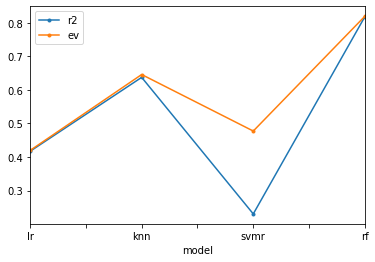

In [56]:
scores.plot(x = 'model',y = ['r2','ev'], style='.-')

Plot predicted and observed data using the best model.

In [0]:
obs_pred.groupby('model').plot(legend=True,subplots = False)

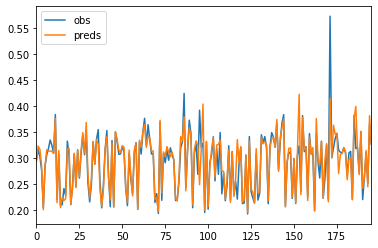

In [57]:
obs_pred[obs_pred.model=="rf"].plot(legend=True,subplots = False)
